## Acknowledgments:

Heavy reference was taken from this kaggle notebook, which implements OpenAI's guided diffusion model from scratch: https://www.kaggle.com/code/vikramsandu/guided-diffusion-by-openai-from-scratch/notebook#Generate. Instead of reproducing this entire pipeline, I decided to focus specifically on the effects of classifier guidance, because this was what I found the most exciting in their methods. Therefore, many of the architectural improvements detailed in the paper and in the Kaggle notebook are not present here becuase of time and resource constraints.


Data was taken from the MNIST dataset: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

Code in this notebook was written with the help of Gemini 3 and Claude Sonnet 4.5. All comments and explanations were written by me alone.

## User Guide:
This [GitHub](https://https://github.com/aalbrechtbuehler/ML4SD-presentation/tree/main) contains trained classifier and unet models. If you want to use those, save them in the same path as this notebook and uncomment the two lines in the **Training Options** and make sure that the training loops above it are commented out (or don't run them). If you want to train from scratch, keep those two lines commented out, and just run all :)

## Global setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

torch.manual_seed(123)
np.random.seed(123)

Using device: cuda


## Data prep and class examples:

First we load the MNIST dataset and normalize our data to work for diffusion. Below is a plot of examples from each class of the MNIST dataset, just to see what we're working with.

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 451kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.6MB/s]


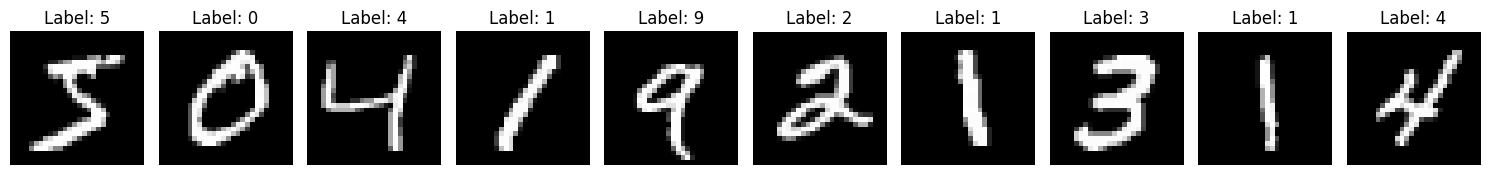

In [2]:
###MNIST hyperparameters###
batch_size = 128
image_size = 28
num_classes = 10

#normalize data to [-1, 1] for diffusion
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#plot some samples to see what we're working with
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Diffusion setup

Next we prepare our diffusion process. This is all very basic, and adapted from the Kaggle notebook.

The main thing to notice here is the classifier integration, where I inject the gradient of the classifier's log probability into the diffusion process.

In [3]:
class LinearDiffusion:

    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.timesteps = timesteps
        self.device = device

        #linear beta schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=self.device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0).to(self.device)

        #diffusion calculated as q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        #posterior calculated as q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)).to(self.device)


    #add noise to samples in forward diffusion
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].to(x_start.device)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].to(x_start.device)

        #reshape
        sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.reshape(-1, 1, 1, 1)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    #denoise with reverse diffusion, with classifier guidance if applicable. Otherwise, unconditional
    def p_sample(self, model, x_t, t, classifier=None, class_label=None, guidance_scale=0.0):
        batch_size = x_t.shape[0]

        #get model prediction
        t_tensor = torch.full((batch_size,), t, device=x_t.device, dtype=torch.long)

        #predict noise
        if guidance_scale > 0 and classifier is not None and class_label is not None:


            # IMPORTANT! Here is where we implement classifier guidance
            with torch.enable_grad():
                x_t_grad = x_t.detach().requires_grad_(True)
                logits = classifier(x_t_grad, t_tensor)
                log_probs = F.log_softmax(logits, dim=-1)
                selected = log_probs[range(len(logits)), class_label]
                grad = torch.autograd.grad(selected.sum(), x_t_grad)[0]

            #diffusion predicted noise estimate
            predicted_noise = model(x_t, t_tensor)

            # - predicted_noise is the diffusion model’s estimate of the noise present in the current image x_t
            # - grad is the classifier gradient, which points in the direction in the latent image space that
            #   increases the probability of the target class—basically, where the image must go to look more like the target class
            # -	Guidance scale is our s
            #   When this is large, the classifier gradient’s influence is larger, which essentially tells the model to move closer to the class prototype.
            #   If this is smaller, there is less push to move closer to the target class
            # - sqrt_one_minus_alphas_cumprod comes from the forward diffusion process and rescales the classifier gradient so that it aligns with the noise

            predicted_noise = predicted_noise - guidance_scale * grad * self.sqrt_one_minus_alphas_cumprod[t].to(x_t.device)
        else:
            #unconditional prediction without classifier guidance input
            predicted_noise = model(x_t, t_tensor)

        #find x_{t-1}
        alpha_t = self.alphas[t].to(x_t.device)
        alpha_cumprod_t = self.alphas_cumprod[t].to(x_t.device)
        beta_t = self.betas[t].to(x_t.device)

        #predict x_0
        x_0_pred = (x_t - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_cumprod_t)
        x_0_pred = torch.clamp(x_0_pred, -1.0, 1.0)

        #calculate the mean
        model_mean = (x_t - beta_t / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_t)

        #at first time step, do nothing
        if t == 0:
            return model_mean
        else:
            #else, add noise
            posterior_variance_t = self.posterior_variance[t].to(x_t.device)
            noise = torch.randn_like(x_t)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

#init
diffusion = LinearDiffusion(timesteps=1000, device=device)

### Recap of forward diffusion

Here’s just a visualization of the forward diffusion process

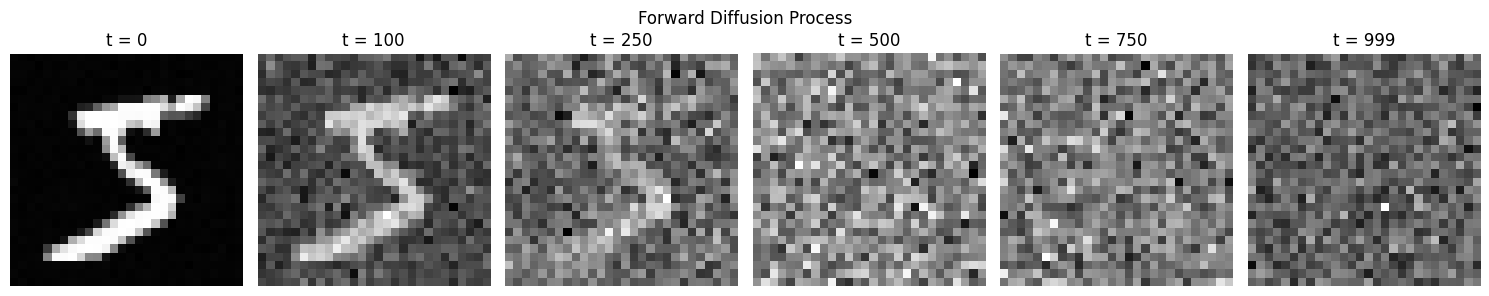

In [4]:
#forward diffusion on a sample image at different timesteps
sample_img, _ = train_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

timesteps_to_show = [0, 100, 250, 500, 750, 999]
fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 3))

for idx, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=device)
    noisy_img = diffusion.q_sample(sample_img, t_tensor)

    axes[idx].imshow(noisy_img.cpu().squeeze(), cmap='gray')
    axes[idx].set_title(f't = {t}')
    axes[idx].axis('off')

plt.suptitle('Forward Diffusion Process')
plt.tight_layout()
plt.show()

## Lightweight diffusion model

I am using a simplified time-embedded UNet architecture here, and leaving out some of the architectural improvements the authors made, because it would take too long and cost too much to run a full model. This demo will just show how classifier guidance works and how different levels affect diversity vs fidelity of samples

In [5]:
#use sinusoidal positional embeddings
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

#important: time-embedding in residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        num_groups = min(8, out_channels)
        while out_channels % num_groups != 0:
            num_groups -= 1

        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t_emb):

        h = self.conv1(F.relu(x))
        h = self.norm1(h)

        #add time embedding here
        h = h + self.time_mlp(F.relu(t_emb))[:, :, None, None]

        h = self.conv2(F.relu(h))
        h = self.norm2(h)

        return h + self.shortcut(x)

#simple UNet, not using many architectural improvements for efficiency
class LightweightUNet(nn.Module):
    """Lightweight U-Net for denoising (~1M parameters) - FIXED"""

    def __init__(self, in_channels=1, model_channels=64, time_emb_dim=128):
        super().__init__()

        #time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        #downsampling
        self.enc1 = ResidualBlock(in_channels, model_channels, time_emb_dim)
        self.down1 = nn.Conv2d(model_channels, model_channels, 3, stride=2, padding=1)

        self.enc2 = ResidualBlock(model_channels, model_channels * 2, time_emb_dim)
        self.down2 = nn.Conv2d(model_channels * 2, model_channels * 2, 3, stride=2, padding=1)

        #bottleneck region
        self.bottleneck = ResidualBlock(model_channels * 2, model_channels * 2, time_emb_dim)

        #upsampling
        self.up1 = nn.ConvTranspose2d(model_channels * 2, model_channels * 2, 4, stride=2, padding=1)
        self.dec1 = ResidualBlock(model_channels * 4, model_channels * 2, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(model_channels * 2, model_channels, 4, stride=2, padding=1)
        self.dec2 = ResidualBlock(model_channels * 2, model_channels, time_emb_dim)

        #output
        self.out = nn.Conv2d(model_channels, in_channels, 1)

    def forward(self, x, t):
        #add time embedding
        t_emb = self.time_embedding(t)

        #encoder
        h1 = self.enc1(x, t_emb)
        h2 = self.enc2(self.down1(h1), t_emb)

        #bottleneck
        h = self.bottleneck(self.down2(h2), t_emb)  # (B, 128, 7, 7)

        #decoder with concatenation
        h = self.dec1(torch.cat([self.up1(h), h2], dim=1), t_emb)
        h = self.dec2(torch.cat([self.up2(h), h1], dim=1), t_emb)

        return self.out(h)


#init
unet = LightweightUNet(in_channels=1, model_channels=64).to(device)

## Lightweight Classifier for Guidance

This is important—here is where I train a separate, albeit basic, time-embedded classifier. The training objective is for it to classify noisy MNIST into 10 classes.

In [6]:
#simple classifier with time-embedding, trained on MNIST data at different noises
class TimeConditionedClassifier(nn.Module):

    def __init__(self, num_classes=10, time_emb_dim=128):
        super().__init__()

        #add time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        #convolution layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        #time mod layers
        self.time_mlp1 = nn.Linear(time_emb_dim, 32)
        self.time_mlp2 = nn.Linear(time_emb_dim, 64)
        self.time_mlp3 = nn.Linear(time_emb_dim, 128)

        #head
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x, t):
        #time embed
        t_emb = self.time_embedding(t)

        #convolution with time embedding
        h = F.relu(self.conv1(x))
        h = h + self.time_mlp1(t_emb)[:, :, None, None]
        h = self.pool(h)

        h = F.relu(self.conv2(h))
        h = h + self.time_mlp2(t_emb)[:, :, None, None]
        h = self.pool(h)

        h = F.relu(self.conv3(h))
        h = h + self.time_mlp3(t_emb)[:, :, None, None]
        h = self.pool(h)

        #classify
        h = h.view(h.size(0), -1)
        h = F.relu(self.fc1(self.dropout(h)))
        h = self.fc2(self.dropout(h))

        return h


#init
classifier = TimeConditionedClassifier(num_classes=num_classes).to(device)

## Training Options

Here is where you should uncomment the model loads if you want to use my pretrained version, otherwise you should uncomment the previous two chunks ad run to trian both models from scratch

In [7]:
#UNCOMMENT THIS IF YOU WANT TO RUN PRE-TRAINED MODELS
classifier.load_state_dict(torch.load('classifier.pth'))
unet.load_state_dict(torch.load('unet.pth'))

#hyperparameters
num_epochs = 30
lr = 2e-4

#basic Adam optimizers
optimizer_unet = torch.optim.Adam(unet.parameters(), lr=lr)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=lr)

#classic loss functions
mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()




### Train UNet

In [8]:
# def train_diffusion_model(model, dataloader, optimizer, diffusion, epochs):
#     model.train()

#     for epoch in range(epochs):
#         total_loss = 0
#         pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')

#         for batch_idx, (images, _) in enumerate(pbar):
#             images = images.to(device)
#             batch_size = images.shape[0]

#             #use random timesteps
#             t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

#             #get noise
#             noise = torch.randn_like(images)

#             #add the noise
#             x_noisy = diffusion.q_sample(images, t, noise=noise)

#             #predict the noise
#             predicted_noise = model(x_noisy, t)

#             #loss calc
#             loss = mse_loss(predicted_noise, noise)

#             #backwards pass
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#             pbar.set_postfix({'loss': f'{loss.item():.4f}'})

#         avg_loss = total_loss / len(dataloader)
#         print(f'Epoch {epoch+1} - Average Loss: {avg_loss:.4f}')

# #now train!
# train_diffusion_model(unet, train_loader, optimizer_unet, diffusion, num_epochs)

even without full architecture in place, this is pretty good performance!

### Train Classifier

In [9]:
# def train_classifier(model, dataloader, optimizer, diffusion, epochs):
#     model.train()

#     for epoch in range(epochs):
#         total_loss = 0
#         correct = 0
#         total = 0

#         pbar = tqdm(dataloader, desc=f'Classifier Epoch {epoch+1}/{epochs}')

#         for batch_idx, (images, labels) in enumerate(pbar):
#             images, labels = images.to(device), labels.to(device)
#             batch_size = images.shape[0]

#             #random timesteps
#             t = torch.randint(0, diffusion.timesteps // 2, (batch_size,), device=device).long()

#             #add noise
#             #this is important, and a mistake I made at first! It is important to train the classifier on
#             #noisy images because we will eventually sample from noisy images in the diffusion model
#             noise = torch.randn_like(images)
#             x_noisy = diffusion.q_sample(images, t, noise=noise)

#             #figure out class
#             logits = model(x_noisy, t)
#             loss = ce_loss(logits, labels)

#             #backwards pass
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             #accuracy
#             _, predicted = torch.max(logits.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             total_loss += loss.item()
#             pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})

#         avg_loss = total_loss / len(dataloader)
#         accuracy = 100 * correct / total
#         print(f'Classifier Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# #now train!
# train_classifier(classifier, train_loader, optimizer_clf, diffusion, num_epochs)

# #Save both models (if training from scratch)
# torch.save(unet.state_dict(), 'unet.pth')
# torch.save(classifier.state_dict(), 'classifier.pth')

Also very good performance

## Sampling

Then I create a sampling function, where I modify the reverse diffusion step by adding the gradient of the classifier's log probability, in order to inject class information back. This is also where the guidance scale is specified

In [11]:
@torch.no_grad()
def sample_images(model, diffusion, classifier=None, class_labels=None,
                 guidance_scale=0.0, num_samples=16, image_size=28):
    model.eval()
    if classifier is not None:
        classifier.eval()

    #start with random noise
    x = torch.randn(num_samples, 1, image_size, image_size, device=device)

    #if we don't have class labels, sample randomly
    if class_labels is None and guidance_scale > 0:
        class_labels = torch.randint(0, num_classes, (num_samples,), device=device)

    #reverse diffusion
    # this is where we input classifier guidance to guide reverse diffusion towards a specific class
    for t in tqdm(reversed(range(diffusion.timesteps)), desc='Sampling', total=diffusion.timesteps):
        x = diffusion.p_sample(model, x, t, classifier, class_labels, guidance_scale)

    return x, class_labels


### Demo: How Classifier Guidance Scales affect sample quality and diversity

here is the main demo: varying the guidance scales and seeing how this affect image sampling. I'm looking at 5 scale values:

- s = 0.0: unconditional sampling, using entire dataset rather than referencing specific class
- s = 1.0: for a fully trained and well-built guided diffusion model, this is the standard scale, guides towards a specific class but doesn't overly limit diversity of samples
  - for this model, this is still too little becuase of limited training and incomplete architecture
- s = 5.0: typically a strong guidance scale, would tend to prefer fidelity over diversity
- s = 10.0: very strong guidance
- s = 10000: asymptotic performance towards fidelity, opposite of unconditional


In [12]:
guidance_scales = [0.0, 1.0, 5.0, 10, 10000] #some guidance scales to look at
fixed_class = 4 #the class we want to produce samples from

samples_per_scale = 16
class_labels_fixed = torch.full((samples_per_scale,), fixed_class, device=device)

all_samples = {}
all_labels = {}

for s in guidance_scales:
    print(f'\nguidance scale s={s}')
    samples, labels = sample_images(
        unet,
        diffusion,
        classifier=classifier if s > 0 else None,
        class_labels=class_labels_fixed if s > 0 else None,
        guidance_scale=s,
        num_samples=samples_per_scale
    )
    all_samples[s] = samples.cpu()
    all_labels[s] = labels.cpu() if labels is not None else None


guidance scale s=0.0


Sampling: 100%|██████████| 1000/1000 [00:04<00:00, 231.16it/s]



guidance scale s=1.0


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 156.92it/s]



guidance scale s=5.0


Sampling: 100%|██████████| 1000/1000 [00:05<00:00, 172.22it/s]



guidance scale s=10


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 155.14it/s]



guidance scale s=10000


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 165.24it/s]


## Visual Comparison

As scale increases, samples become less diverse, referencing a specific class more closely, and by s = 10000 are overfitted because the diversity is too low and you have lost too much conditional information


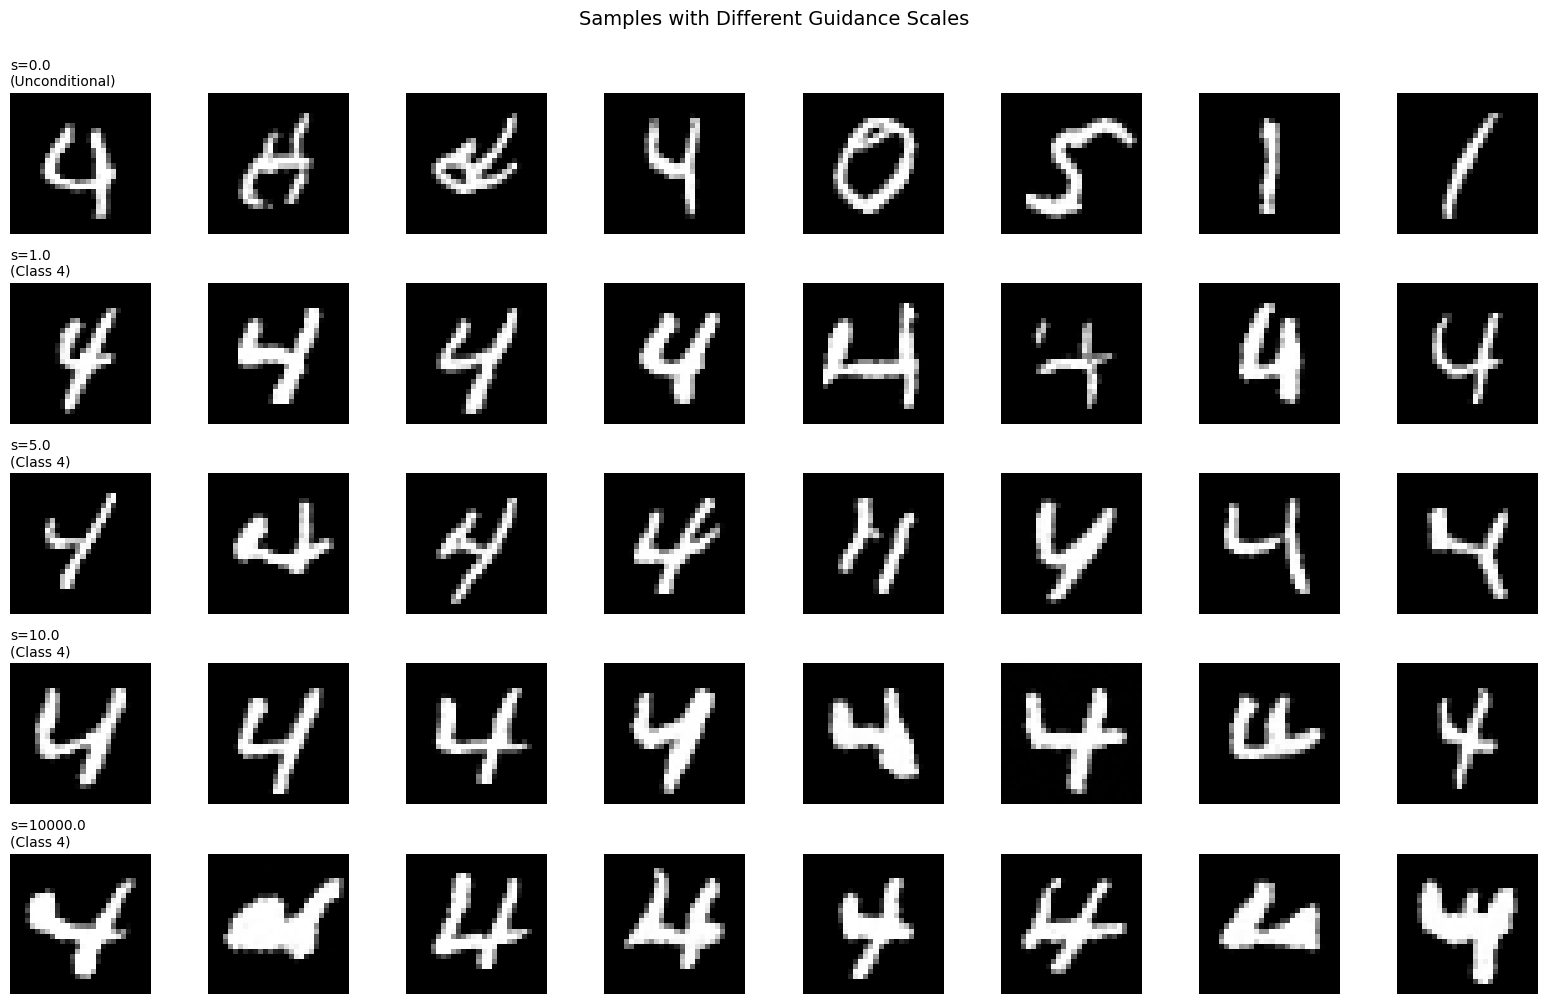

In [13]:
#plot our samples by guidance scale
fig, axes = plt.subplots(len(guidance_scales), 8, figsize=(16, 2*len(guidance_scales)))

for row_idx, s in enumerate(guidance_scales):
    samples = all_samples[s]
    labels = all_labels[s]

    for col_idx in range(8):
        img = samples[col_idx].squeeze()
        img = (img + 1) / 2
        img = torch.clamp(img, 0, 1)

        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')

        if col_idx == 0:
            if s == 0:
                title = f's={s:.1f}\n(Unconditional)'
            else:
                title = f's={s:.1f}\n(Class {fixed_class})'
            axes[row_idx, col_idx].set_title(title, fontsize=10, loc='left')

plt.suptitle('Samples with Different Guidance Scales', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

## Interpretation:

You can see that as guidance scale increases, diversity decreases but fidelity increases. With an unconditional diffusion process, samples belong to many different classes (some are not numbers at all). However, as s increases, samples become much more interpretable as the correct number (in this case, 4), and asymptotically become more and more uniform. I find the s = 10000 samples quite interesting, because my intuition was that at some point they would become all look identical. But, i guess that because we do start slightly randomly, what happens instead is that the diffusion has become so attuned to the class "peaks" in latent space that it is no longer able to adapt conditional on attributes unique to each sample (due to the random initialization). This may explain why some samples are back to not looking like 4's.

So, overall, even though my models were drastically simplified, this coincides with Dhariwal & Nichol's findings, where classifier guidance is a successful method to guide diffusion towards specific classes, and increasing the guidance scale reduces sampling diversity but enhances fidelity.  